Let's consider the problem of fitting some data points to a straight line model
\begin{equation}
y = m x + b
\end{equation}
Using Python, we have SO MANY ways of doing this fit and getting errors on the derived slope and intercept. 

0) Since this is a linear model, we have the analytical formula using matrix operations.  Here we calculate the covariance matrix ourselves.

1) `numpy.polyfit`.  Again, to get the covariance we expect we have to use a keyword: `cov='unscaled'`

2) `scipy.optimize.curve_fit`.  `curve_fit` will return a covariance, but to get the one we think we should get, we need to tell it `absolute_sigma=True`.

3) `astropy.modeling`.  To get `astropy` to return a covariance matrix for the parameters, we need to use `fitting.LevMarLSQFitter` (Levenberg-Marquardt least-squares algorithm) and not `fitting.LinearLSQFitter`.  

They all give the same answer, and the same (analytical) covariance.  Let's see if we can get this covariance from the data.  We can use any method with multiple simulations to derive a covariance from the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy.stats as stats
from scipy.optimize import curve_fit

In [30]:
# A useful function for histograms
def BinCenter(edge):
    centers = (edge[1:]+edge[0:-1])/2.
    return centers

In [2]:
# define a model for a line (uses astropy models, but not the fitting functions)
m0 = 1.0
b0 = 0.0
line_orig = models.Linear1D(slope=m0, intercept=b0)

# generate x, y data non-uniformly spaced in x
# add noise to y measurements
npts = 30
#np.random.seed(10)
x = np.random.uniform(0.0, 10.0, npts)
y = line_orig(x)
yunc = np.random.normal(0.0, 0.5, npts)
y += yunc

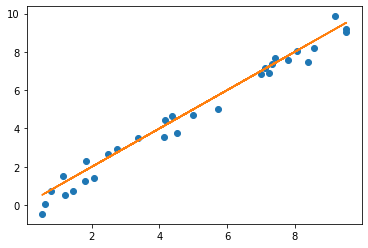

In [3]:
plt.plot(x, y, 'o')
plt.plot(x, line_orig(x))
plt.show()

Below we're going to define a linear fit according to the linear least squares mathematics, with the weight matrix $W$ assumed to be the identity (`np.eye`, get it?) if none is provided.  Note that `np.matmul` is matrix multiplication in the usual way, so
\begin{equation}
X^T W X
\end{equation}
for example, is written as `np.matmul(X.T, np.matmul(W, X))`.  That is, first multiply $W X$ (order matters!) and then multiply $X^T$ on that product.

In [4]:
def LinearFit(x, y, W = None):
    
    if W is None:
        W = np.eye(len(x))
        
    # Make the matrix X.  
    # A constant vector, and a vector proportional to the independent variable x
    X = np.array([[np.ones_like(x)], [x]]).squeeze().T
    Cinv = np.matmul(X.T, np.matmul(W, X))
    C = np.linalg.inv(Cinv)
    params = np.matmul(C, np.matmul(X.T, np.matmul(W, y)))
    return params, C

In [5]:
params, C = LinearFit(x, y)
print('Parameters')
print(params)
print('Covariance')
print(C)

Parameters
[-0.30139698  1.01698635]
Covariance
[[ 0.12056624 -0.01803775]
 [-0.01803775  0.00372979]]


In [6]:
# Polyfit
p, cov = np.polyfit(x, y, 1, cov='unscaled')
print('Parameters')
print(p)
print('Covariance')
print(cov)

Parameters
[ 1.01698635 -0.30139698]
Covariance
[[ 0.00372979 -0.01803775]
 [-0.01803775  0.12056624]]


In [7]:
def Line(x, m, b):
    return m * x + b

params, params_covariance = curve_fit(Line, x, y, p0=[1, 0], absolute_sigma=True)
print('Parameters')
print(params)
print('Covariance')
print(params_covariance)

Parameters
[ 1.01698635 -0.30139697]
Covariance
[[ 0.00372979 -0.01803774]
 [-0.01803774  0.12056623]]


The tutorial page for using the `astropy` fitting functions:

https://docs.astropy.org/en/stable/modeling/example-fitting-line.html

In [8]:
# Use astropy
# Initialize a linear fitter
fit = fitting.LinearLSQFitter()
# initialize a linear model
line_init = models.Linear1D()
# Initialize the truth
line_orig = models.Linear1D(slope=m0, intercept=b0)

In [9]:
# The astropy method
# initialize a linear fitter
#fit = fitting.LinearLSQFitter() # for some reason, this does not compute a covariance matrix
fit = fitting.LevMarLSQFitter()

# initialize a linear model
line_init = models.Linear1D(slope=m0, intercept=b0)

# fit the data with the fitter
fitted_line = fit(line_init, x, y)

print(fitted_line)
print(fit.fit_info['param_cov'])

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope             intercept     
    ------------------ -------------------
    1.0169863507933898 -0.3013969812823536
[[ 0.00076125 -0.0036815 ]
 [-0.0036815   0.02460754]]


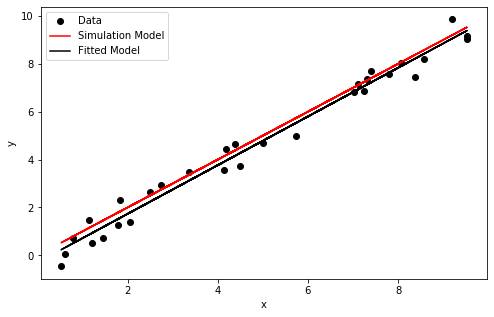

In [10]:
# plot
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko', label='Data')
plt.plot(x, line_orig(x), 'r-', label='Simulation Model')
plt.plot(x, fitted_line(x), 'k-', label='Fitted Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [11]:
%%time
# Create many realizations of the random errors (sometimes termed "noise").
Nrlz = 10000
npts = 30
sigma = 1.0
# We have 
slopes = np.zeros(Nrlz) 
intercepts = np.zeros(Nrlz)
covariances = np.zeros([Nrlz,2,2])
for i in np.arange(Nrlz):
    # Generate the random x, y positions, values and errors
    x = np.random.uniform(0.0, 10.0, npts)
    y = line_orig(x) + np.random.normal(0.0, sigma, npts)
    
    # fit the data with the astropy fitter ... they're all the same
    fitted_line = fit(line_init, x, y)
    # save the result
    slopes[i] = fitted_line.slope.value
    intercepts[i] = fitted_line.intercept.value
    covariances[i,:,:] = fit.fit_info['param_cov']

CPU times: user 17.7 s, sys: 29.3 ms, total: 17.7 s
Wall time: 17.7 s


In [12]:
empirical_data = (np.array([[slopes], [intercepts]])).squeeze()
empirical_covariance = np.cov(empirical_data)
empirical_correlation = np.corrcoef(empirical_data)

We have a different covariance from each fit, and they are slightly different because we changed the spacing of the x values.  So we have a list that's [Nrlz, 2, 2], so we are literally going to average the matrices over all Nrlz different versions, which we do with the `numpy` command below:

In [13]:
analytic_covariance = covariances.mean(axis=0)
print(analytic_covariance)

[[ 0.00426384 -0.0213087 ]
 [-0.0213087   0.14109685]]


We can also use the fitted values from our simulations to show the distribution of the fitted slopes and intercepts.

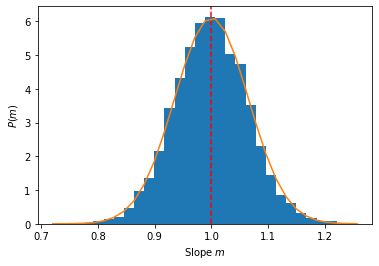

In [14]:
m_hist, m_bins, patches = plt.hist(slopes, bins=30, density=True)
plt.axvline(m0, color='red', linestyle='--')
plt.plot(m_bins, stats.norm.pdf(m_bins, loc=1., scale=np.sqrt(analytic_covariance[0,0])))
plt.xlabel(r'Slope $m$')
plt.ylabel(r'$P(m)$')
plt.show()

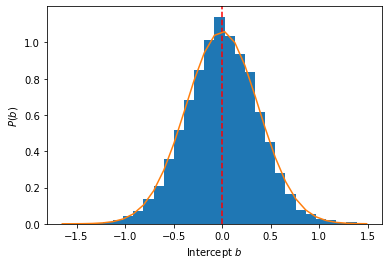

In [15]:
b_hist, b_bins, patches = plt.hist(intercepts, bins=30, density=True)
plt.axvline(b0, color='red', linestyle='--')
plt.plot(b_bins, stats.norm.pdf(b_bins, loc=0., scale=np.sqrt(analytic_covariance[1,1])))
plt.xlabel(r'Intercept $b$')
plt.ylabel(r'$P(b)$')
plt.show()

In [16]:
print('Empirical Covariance')
print(empirical_covariance)
print('Average of Analytic Covariance')
print(analytic_covariance)

Empirical Covariance
[[ 0.00419498 -0.02087096]
 [-0.02087096  0.13844619]]
Average of Analytic Covariance
[[ 0.00426384 -0.0213087 ]
 [-0.0213087   0.14109685]]


We can visualize the simulated *variances* as these histograms, but how should we think about the *covariance*?  Well, we can certainly histogram the off-diagonal values that would go into the sum that `np.cov` is computing, namely 
\begin{equation}
c_i = (b_i - \bar{b})(m_i - \bar{m})
\end{equation}
This is particularly simple because we only have two parameters.

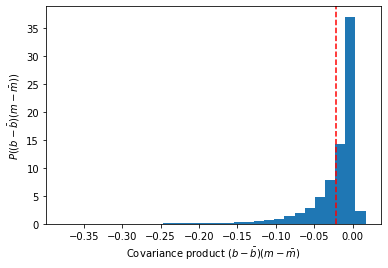

In [17]:
partial_cov = (intercepts - intercepts.mean())*(slopes - slopes.mean())
cov_hist, cov_bins, patches = plt.hist(partial_cov, bins=30, density=True)
plt.axvline(analytic_covariance[0,1], color='red', linestyle='--')
#plt.plot(b_bins, stats.norm.pdf(b_bins, loc=0., scale=np.sqrt(np.abs(analytic_covariance[0,1])))
plt.xlabel(r'Covariance product $(b-\bar{b})(m-\bar{m})$')
plt.ylabel(r'$P((b-\bar{b})(m-\bar{m}))$')
plt.show()

The average of these products *does* produce the measured covariance, but clearly this is not a Gaussian distribution.

In [18]:
partial_cov.mean()

-0.020868869526187446

Another way to think about the covariance between the two parameters is just to make a scatter plot of intercept vs. slope:

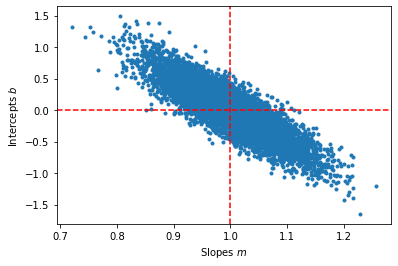

In [24]:
plt.plot(slopes, intercepts, '.')
plt.axvline(m0, color='red', linestyle='--')
plt.axhline(b0, color='red', linestyle='--')
plt.ylabel(r'Intercept $b$')
plt.xlabel(r'Slope $m$')
plt.show()

We can thinking of this as measurig the *joint probability* of measuring a given $m$ and $b$.  One thing we can notice is that the probabilities are *correlated* (actually, anti-correlated).  We can see this because if my value of $b<b_0$, my value of $m$ is far more likely to be $m>m_0$ (and vice versa) whereas if the variables were uncorrelated, there would be an equal chance of finding a value of $m < m_0$.  This manifests as a *slope* in the orientation of the ellipse above.  

In [20]:
empirical_correlation

array([[ 1.        , -0.86603795],
       [-0.86603795,  1.        ]])

The correlation matrix $R$ above is defined as
\begin{equation}
R_{ij} = \frac{C_{ij}}{\sigma_i \sigma_j}
\end{equation}
where $C_{ij}$ is the covariance matrix and 
\begin{equation}
\sigma^2_i \equiv C_{ii}
\end{equation} 
We show below how to calculate this using `numpy` tricks:

In [77]:
# Take the diagonal elements of the covariance and take their square root
norm = np.sqrt(np.diag(empirical_covariance))
# Use the outer product to compute all the sigma_i sigma_j pairs
norm_outer = np.outer(norm, norm)
# Then do an element-by-element division
print(empirical_covariance/norm_outer)

[[ 1.         -0.86603795]
 [-0.86603795  1.        ]]


This way of writing things makes it much more apparent that errors on the slope and intercept are highly correlated.  (What would the correlation matrix look like for uncorrelated errors?)

The scatter plot clearly shows the slope of the ellipse, which is related to this (anti)-correlation.  One disadvantage of that plot, though, is that its hard to tell how much more likely any given position in the $(m,b)$ plane is.  It would be good to be able to plot the density of points as a contour plot or an intensity image.  To do this, we need to effectively create a 2-D histogram.  We can also add a contour plot on top of the histogram.

In [78]:
import scipy.ndimage

In [79]:
h_mb, x_mb, y_mb = np.histogram2d(slopes, intercepts, bins=30, density=True)
# Do some smoothing for the contours
smfac = 3
h_mb_sm = scipy.ndimage.zoom(h_mb,[smfac, smfac])
x_mb_sm = scipy.ndimage.zoom(BinCenter(x_mb),smfac)
y_mb_sm = scipy.ndimage.zoom(BinCenter(y_mb),smfac)
levels = h_mb_sm.max()*np.linspace(0.2,0.9,num=4)

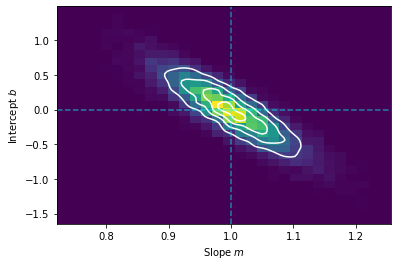

In [80]:
_, _, _, _ = plt.hist2d(slopes, intercepts, bins=30, density=True)
#plt.contour(BinCenter(x_mb), BinCenter(y_mb), h_mb, colors='white', levels=4)
plt.contour(x_mb_sm, y_mb_sm, h_mb_sm, colors='white', levels=levels)
plt.axvline(m0, color='cyan', linestyle='--', alpha=0.5)
plt.axhline(b0, color='cyan', linestyle='--', alpha=0.5)
plt.ylabel(r'Intercept $b$')
plt.xlabel(r'Slope $m$')
plt.show()